# HW1 : Regression, Cross-Validation, and  Regularization

In [1]:
import os
import numpy as np
import warnings

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model
import sklearn.neighbors
import sklearn.model_selection

from sklearn.pipeline import Pipeline
from cross_validation import train_models_and_calc_scores_for_n_fold_cv,make_train_and_test_row_ids_for_n_fold_cv

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Set random seed to make all computations reproducible

In [3]:
SEED = 12345

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [4]:
#DATA_DIR = '../data_auto/'
DATA_DIR = ''

In [5]:
x_tr_MF = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_NF = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_PF = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

In [6]:
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_P = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

In [7]:
print('x_tr_MF', x_tr_MF.shape, type(x_tr_MF))
print('x_va_NF', x_va_NF.shape)
print('x_te_PF', x_te_PF.shape)
print('y_tr_M', y_tr_M.shape)
print('y_va_N', y_va_N.shape)
print('y_te_P', y_te_P.shape)

x_tr_MF (192, 4) <class 'numpy.ndarray'>
x_va_NF (100, 4)
x_te_PF (100, 4)
y_tr_M (192,)
y_va_N (100,)
y_te_P (100,)


# Load completed code

In [8]:
from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from performance_metrics import calc_mean_squared_error

# Define useful plotting functions

In [9]:
def plot_train_and_valid_error_vs_degree(
        degree_list, err_tr_list=None, err_va_list=None):
    ''' Plot provided errors versus degrees on a new figure
    '''
    if err_va_list is not None:
        plt.plot(degree_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(degree_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, 74]); # Do NOT change this! Helps all reports look the same.
    plt.legend(loc='upper right'); # Always include a legend

# Define methods for building pipelines

Remember, we discussed pipelines in the lab from day04 on "Feature Engineering"

In [10]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [11]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('ridge_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

In [12]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    pipeline = make_poly_linear_regr_pipeline(degree)
    # TODO train this pipeline on provided training data
    pipeline.fit(x_tr_MF, y_tr_M)
    # Compute training error
    yhat_tr_M = pipeline.predict(x_tr_MF)   # TODO fixme
    err_tr = sklearn.metrics.mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    
    # Compute validation error
    yhat_va_N = pipeline.predict(x_va_NF)  # TODO fixme
    err_va = sklearn.metrics.mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)

In [13]:
print('fv_err_tr_list:', fv_err_tr_list)
print('fv_err_va_list:', fv_err_va_list)

fv_err_tr_list: [17.95482444211353, 13.947809429967464, 11.452876921225453, 8.412902227196776, 5.246464930945852, 0.30000184893558374, 0.013837239719832079]
fv_err_va_list: [19.0126711197124, 15.793274734511765, 17.28284331205879, 67.82032382050369, 2.2100038527948263e+19, 2.0063332724445501e+18, 1.429446894638988e+16]


In [14]:
pipeline = make_poly_linear_regr_pipeline(degree=6)
pipeline.fit(x_tr_MF, y_tr_M)
print('The intercept coefficient value is: ', pipeline.named_steps["linear_regr"].intercept_ )

The intercept coefficient value is:  12901018868.880665


In [15]:
arr = pipeline.named_steps["linear_regr"].coef_
print( 'The minimum weight coefficient is: ', min(arr), '\nThe maxmium weight weight coefficient is: ', max(arr))

The minimum weight coefficient is:  -9693867535991.963 
The maxmium weight weight coefficient is:  5546360787986.932


### Figure 1: Error vs degree

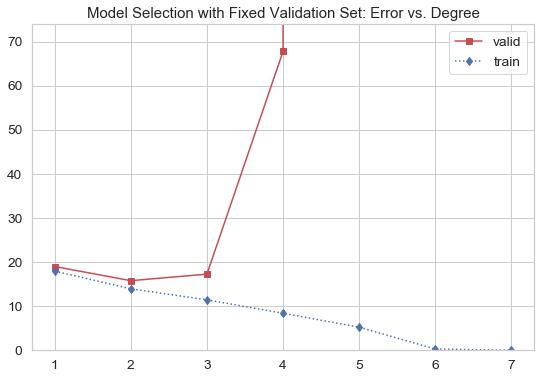

In [16]:
plt.figure(figsize=(9,6))
plot_train_and_valid_error_vs_degree(degree_list, fv_err_tr_list, fv_err_va_list);
plt.title('Model Selection with Fixed Validation Set: Error vs. Degree');
plt.savefig('figure1-err_vs_degree-fv.pdf')

### Prediction 1: Score on the test set using the chosen model

In [17]:
# TODO compute score on test set for later
pipeline = make_poly_linear_regr_pipeline(degree = 2)
pipeline.fit(x_tr_MF, y_tr_M)
yhat_te_P = pipeline.predict(x_te_PF)
err_te = sklearn.metrics.mean_squared_error(y_te_P, yhat_te_P)

In [18]:
print("Selected Parameters:")
print("Degree=2")
print("Fixed validation set estimate of heldout error:")
print(fv_err_va_list[1])
print("Error on the test-set:")
print(err_te)
print('Mean Square error on the test-set:\n',np.sqrt(err_te))

Selected Parameters:
Degree=2
Fixed validation set estimate of heldout error:
15.793274734511765
Error on the test-set:
15.932092578370812
Mean Square error on the test-set:
 3.9915025464567617


# Problem 2: Cross Validation for Polynomial Feature Regression

In [19]:
x_trva_LF = np.vstack((x_tr_MF.copy(), x_va_NF.copy())) # TODO fix concat your train and validation set x values
y_trva_L = np.append(y_tr_M.copy(), y_va_N.copy())    # TODO fix concat your train and validation set y values
print(x_trva_LF.shape)
print(y_trva_L.shape)

(292, 4)
(292,)


In [20]:
K = 10 # num folds
L,F = x_trva_LF.shape
degree_list = [1, 2, 3, 4, 5, 6, 7]
cv_err_tr_list = []
cv_err_va_list = []

for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    # tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv() # TODO
    pipeline_cv = make_poly_linear_regr_pipeline(degree) 
    train_ids_per_fold, test_ids_per_fold = make_train_and_test_row_ids_for_n_fold_cv(n_examples=L, n_folds=K, random_state=SEED)
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline_cv, x_trva_LF, y_trva_L, n_folds=K, random_state=SEED)
    err_tr = np.mean(tr_error_K) # TODO fixme, compute average error across all train folds
    err_va = np.mean(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
    cv_err_tr_list.append(err_tr)
    cv_err_va_list.append(err_va)

In [21]:
cv_err_tr_list, cv_err_va_list

([18.13810024059878,
  14.206140715773198,
  12.321190709028915,
  9.617530571040216,
  7.646628889380463,
  3.9363387390869113,
  0.43556490614868276],
 [18.802745318693177,
  16.266193249812794,
  40.29725309942502,
  6.896589304414372e+16,
  2.2916699676355002e+21,
  3.6276118455465206e+21,
  7701438886403666.0])

### Figure 2: Error vs degree

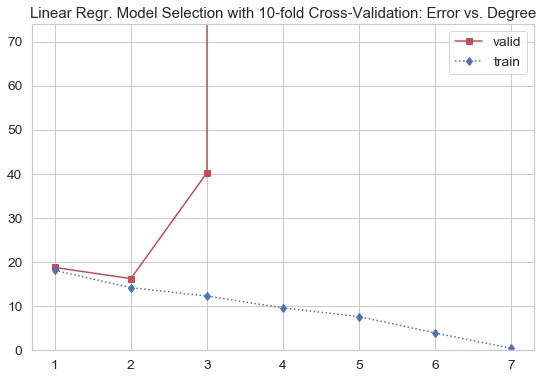

In [22]:
plt.figure(figsize=(9,6))
plot_train_and_valid_error_vs_degree(degree_list, cv_err_tr_list, cv_err_va_list)
plt.title('Linear Regr. Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure2-err_vs_degree-cv-seed=%d.pdf' % SEED)

### Prediction 2: Score on the test set using the chosen model

Use the chosen hyperparameters, retrain ONE model on the FULL train+valid set.
Then make predictions on the heldout test set.

In [23]:
# TODO compute score on test set for later 
## choose degree=2
pipeline_cv = make_poly_linear_regr_pipeline(degree=2) 
pipeline_cv.fit(x_trva_LF, y_trva_L)
yhat_te_P_cv = pipeline_cv.predict(x_te_PF)
err_te_cv = sklearn.metrics.mean_squared_error(y_te_P, yhat_te_P_cv)
print('err_te_cv: ', err_te_cv)

err_te_cv:  15.334679184359443


In [24]:
print("Selected Parameters:")
print("Degree = 2")
print("10-fold CV estimate of heldout error:")
print(cv_err_va_list[1])
print("Error on the test-set:")
print(err_te_cv)
print('Mean Square error on the test-set:\n',np.sqrt(err_te_cv))

Selected Parameters:
Degree = 2
10-fold CV estimate of heldout error:
16.266193249812794
Error on the test-set:
15.334679184359443
Mean Square error on the test-set:
 3.9159518873907837


# Problem 3: Cross Validation for Ridge Regression

In [25]:
alpha_grid = np.logspace(-6, 6, 13) # 10^-6, 10^-5, 10^-4, ... 10^-1, 10^0, 10^1, ... 10^6

degree_list = [1, 2, 3, 4, 5, 6, 7]

K = 10 # num folds
ridge_cv_err_tr_list = []
ridge_cv_err_va_list = []

ridge_param_list = list()

for degree in degree_list:
    for alpha in alpha_grid:
        ridge_param_list.append(dict(alpha=alpha, degree=degree))
        # TODO create a pipeline using features with current degree value
        pipeline_rr = make_poly_ridge_regr_pipeline(degree, alpha=alpha) 
        # TODO call your function to train a separate model for each fold and return train and valid errors
        # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
        # tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv() # TODO
        train_ids_per_fold, test_ids_per_fold = make_train_and_test_row_ids_for_n_fold_cv(n_examples=L, n_folds=K, random_state=SEED)
        tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline_rr, x_trva_LF, y_trva_L, n_folds=K, random_state=SEED)
        err_tr = np.mean(tr_error_K) # TODO fixme, compute average error across all train folds
        err_va = np.mean(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
        ridge_cv_err_tr_list.append(err_tr)
        ridge_cv_err_va_list.append(err_va)

In [26]:
j = 1
print('For alpha = 0.1: ')
for i in range(5,len(ridge_cv_err_va_list),13):
    print('Degree =',j, ', ridge_cv_err_va =', ridge_cv_err_va_list[i])
    j = j + 1

For alpha = 0.1: 
Degree = 1 , ridge_cv_err_va = 18.784175412542044
Degree = 2 , ridge_cv_err_va = 15.873452392311526
Degree = 3 , ridge_cv_err_va = 15.6564503474716
Degree = 4 , ridge_cv_err_va = 15.545712105460577
Degree = 5 , ridge_cv_err_va = 15.436319499286588
Degree = 6 , ridge_cv_err_va = 15.355813278405398
Degree = 7 , ridge_cv_err_va = 15.292202802995925


### Figure 3: Error vs degree at alpha = 10^-3, alpha = 0.1, alpha = 1000

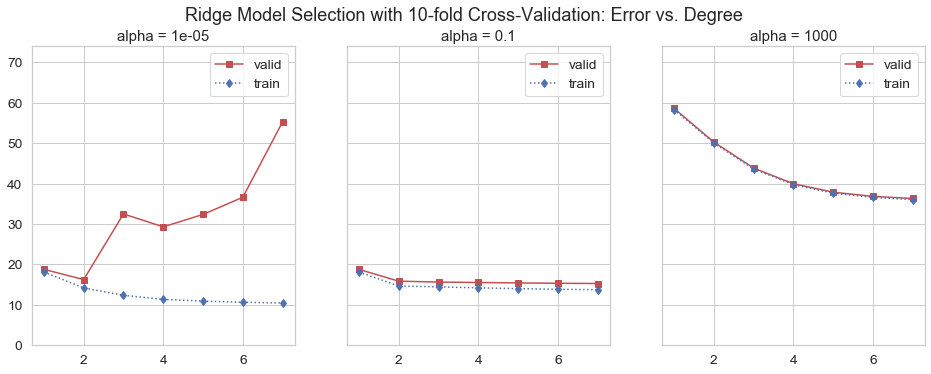

In [27]:
fig, ax_grid = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(16, 5.5))

for aa, alpha in enumerate([0.00001, 0.1, 1000.0]):
    # Find the elements of the param list that correspond to setting alpha to specific value
    match_ids = [pp for pp in range(len(ridge_param_list)) if np.allclose(alpha, ridge_param_list[pp]['alpha'])]
    train_err = np.asarray(ridge_cv_err_tr_list)[match_ids]
    test_err = np.asarray(ridge_cv_err_va_list)[match_ids]

    # Select which panel (of the 3 in figure) to be current active axis
    cur_ax = ax_grid[aa]
    plt.sca(cur_ax);
    
    # Set the title of the active axis
    cur_ax.set_title('alpha = %.5g' % alpha)

    # Draw line plot in active axis
    plot_train_and_valid_error_vs_degree(degree_list, train_err, test_err)

plt.suptitle('Ridge Model Selection with 10-fold Cross-Validation: Error vs. Degree');
plt.savefig('figure3-3_panels_by_alpha-err_vs_degree-seed=%d.pdf' % SEED, pad_inches=0, bbox_inches='tight')

### Prediction 3: Score on the test set using the chosen model


In [28]:
# TODO compute score on test set for later 
## choose degree=2
pipeline_rr = make_poly_ridge_regr_pipeline(degree=2, alpha=0.1) 
pipeline_rr.fit(x_trva_LF, y_trva_L)
yhat_te_P_rr = pipeline_rr.predict(x_te_PF)
err_te_rr = sklearn.metrics.mean_squared_error(y_te_P, yhat_te_P_rr)
print('err_te_rr: ', err_te_rr)

err_te_rr:  14.873894376805325


In [29]:
print("Selected Parameters (alpha and degree):")
print("alpha = 0.1, degree = 2")
print("10-fold CV estimate of heldout error:")
print(ridge_cv_err_va_list[18])
print("Error on the test-set:")
print(err_te_rr)
print('Mean Square error on the test-set:\n',np.sqrt(err_te_rr))

Selected Parameters (alpha and degree):
alpha = 0.1, degree = 2
10-fold CV estimate of heldout error:
15.873452392311526
Error on the test-set:
14.873894376805325
Mean Square error on the test-set:
 3.8566688186575373


# Problem 4 

## find the RMSE for baseline

In [30]:
mean_arr = np.array([np.mean(y_tr_M)] * len(y_tr_M))

In [31]:
rmse_baseline = np.sqrt(sklearn.metrics.mean_squared_error(y_tr_M, mean_arr))
rmse_baseline

8.231074409668523